In [ ]:
import numpy as np

In [ ]:
import numpy as np
import os
import shutil
import glob
from clease.settings import Concentration
from clease.settings import CEBulk
from clease.structgen import NewStructures
from ase.db import connect
from ase.io import read as ase_read
from ase.visualize import view
from ase.calculators.eam import EAM
from clease.tools import update_db
from clease import Evaluate
from clease import NewStructures
from clease.calculator import attach_calculator
from clease.montecarlo import Montecarlo
import clease

# from gpaw import GPAW
from ase.calculators.emt import EMT
import json

import clease.plot_post_process as pp
import matplotlib.pyplot as plt

In [2]:
from ase.calculators.lammpslib import LAMMPSlib

cmds = ["pair_style eim",
        "pair_coeff * * Na Li /Users/Michael_wang/Documents/venkat/cleaseASEcalc/ffield.eim Na Li"]
rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiNa"

ASElammps = LAMMPSlib(lmpcmds=cmds, keep_alive=True)

In [ ]:
from ase.calculators.lammpslib import LAMMPSlib

cmds0 = ["pair_style eim",
        "pair_coeff * * Na /Users/Michael_wang/Documents/venkat/cleaseASEcalc/ffield.eim Na"]
rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiNa"
ASElammps0 = LAMMPSlib(lmpcmds=cmds0, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlogNa.log"))

cmds1 = ["pair_style eim",
        "pair_coeff * * Li /Users/Michael_wang/Documents/venkat/cleaseASEcalc/ffield.eim Li"]
rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiNa"
ASElammps1 = LAMMPSlib(lmpcmds=cmds1, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlogLi.log"))

cmds = ["pair_style eim",
        "pair_coeff * * Na Li /Users/Michael_wang/Documents/venkat/cleaseASEcalc/ffield.eim Na Li"]
rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiNa"
ASElammps = LAMMPSlib(lmpcmds=cmds, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlog.log"))

In [21]:
# db_del = connect("LiNa/LiNa-merged-new.db")
# db_del.delete([57])

In [15]:
import re

db = connect("LiNa/LiNa-merged-EIM.db")
db_2 = connect("LiNa/LiNa-merged-EIM-scaled.db")

Li = 3.51
Na = 4.29

for idx, row in enumerate(db.select('')):
    atoms = row.toatoms()

    # atoms.cell *= 3.9/3.51
    # atoms.positions *= 3.9/3.51
    # db_2.write(atoms)
    # continue

    sperated = re.split('Li|Na', row.formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        scale = (3.51 * float(sperated[1]) + float(sperated[2]) * 4.29)   /3.51/(float(sperated[1]) + float(sperated[2]))
        atoms.cell *= scale
        atoms.positions *= scale
        db_2.write(atoms)
    else:
        if row.formula[:2] == "Li":
            scale = 3.51/3.9
            atoms.cell *= scale
            atoms.positions *= scale
            db_2.write(atoms)
        elif row.formula[:2] == "Na":
            scale = 4.29/3.9
            atoms.cell *= scale
            atoms.positions *= scale
            db_2.write(atoms)
        else:
            assert False


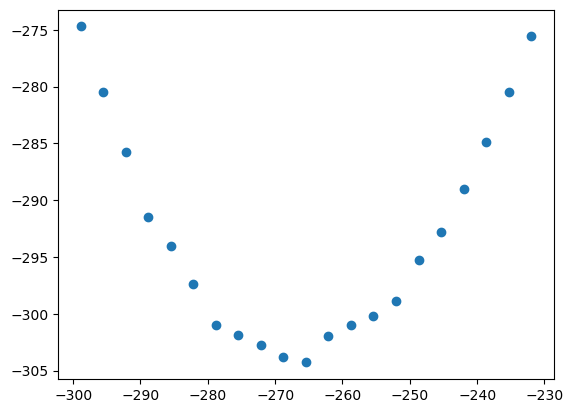

In [15]:
plt.plot(DFTs, EMTs, 'o')

In [ ]:
db_name = "LiNa/LiNa-Sep1-first-Batch-3.9.db"
conc = Concentration(basis_elements=[['Li', 'Na']])

hhsettings = CEBulk(crystalstructure='bcc',
                  a=3.9,
                  supercell_factor=64,
                  concentration=conc,
                  db_name=db_name,
                  max_cluster_dia=[4.5,4.5,4.5],
                  basis_func_type="polynomial")

In [ ]:
import re, numpy

def get_conc_from_formula(formula):
    sperated = re.split('Li|Na', formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        return int(sperated[1])/(int(sperated[2]) + int(sperated[1]))
    elif len(sperated) == 2:
        if formula[:2] == "Li":
            return 1
        elif formula[:2] == "Na":
            return 0
    return numpy.inf

In [ ]:
def energy_correction(self, formula, E):
    sperated = re.split('Li|Na', formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        return E + int(sperated[1])*193.893 + int(sperated[2])*1296.886
    elif len(sperated) == 2:
        if formula[:2] == "Li":
            return E + int(sperated[1])*193.893
        elif formula[:2] == "Na":
            return E + int(sperated[1])*1296.886
    return np.inf

In [ ]:
with open('LiNa/LiNa-merged.db-eci.json') as f:
    eci = json.load(f)

x = []
E = []

db2run = connect("LiNa/LiNa-Aug2-first-Batch.db")
for row in db2run.select(''):
    fomula = row.formula
    if fomula != "Li":
        x.append(get_conc_from_formula(fomula))
        atoms = row.toatoms()
        # atoms = attach_calculator(hhsettings, atoms=atoms, eci=eci)
        atoms.calc = ASElammps
        E.append(atoms.get_potential_energy())

Na = E[0]
Li = E[-1]

for i in range(len(E)):
    E[i] = (E[i] - x[i]*Li - (1-x[i])*Na)/80

plt.plot(x,E, "o--")
plt.title("Toy Model Formation Energy")
plt.ylabel("eV/atom")
plt.xlabel("x")

In [4]:
genNum = 12

In [7]:
atoms = hhsettings.prim_cell.copy()
atoms.numbers[0] = 11
atoms *= (4,4,4)
ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
ns.insert_structure(atoms)
genNum += 1

In [43]:
atoms = hhsettings.prim_cell.copy()
atoms.numbers[0] = 3
atoms *= (4,4,4)
changeToNa = [15, 41, 32, 3, 38, 6, 54, 18, 27, 46, 29, 11, 62, 9, 60, 48, 13, 61, 30, 52, 43, 25, 7, 53, 26, 37, 1, 55, 34, 35, 16, 45]
for i in changeToNa:
    atoms.numbers[i] = 11
# atoms *= (2,2,2)

# # atoms.numbers[0] = 3
# # atoms.numbers[7] = 11

atoms.write("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/2bSaved/0.5.3.db")

In [44]:
view(atoms)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [45]:
myDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/2bSaved"
dbSave = connect("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/2bSaved/LiNaToy2.db")
dbs = os.listdir(myDir)

for n in dbs:
    if n[0] != '.':
        db = connect(os.path.join("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/2bSaved", n))
        for row in db.select(''):
            atoms = row.toatoms()
            print(atoms)
            dbSave.write(atoms)



Atoms(symbols='Li24Na40', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li32Na32', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li24Na40', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li56Na8', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li8Na56', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li40Na24', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li8Na56', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li40Na24', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li8Na56', pbc=True, cell=[[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]], tags=...)
Atoms(symbols='Li40Na24', pbc=True, cell=

In [36]:
db = connect("LiNa/LiNa-Aug2-first-Batch2-Kian.db")
for row in db.select(''):
    print(row)

<AtomsRow: formula=Li, keys=name>
<AtomsRow: formula=Na80, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li4Na76, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li8Na72, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li12Na68, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li16Na64, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li20Na60, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li28Na52, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li32Na48, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li32Na48, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li36Na44, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li40Na40, key

In [3]:
genNum = 1

In [6]:
from KianCalculator import KianCalc
calc = KianCalc("LiNa/LiNaToy-1-Kian.db")

db = connect("LiNa/LiNa-merged-new.db")

for row in db.select(converged=False):
    print("???")
    atoms = row.toatoms()
    atoms.calc = calc
    if calc.has_energy(row.formula):
        atoms.get_potential_energy()
        update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)

(1, 5, 7, 8, 9, 15)

In [ ]:
from KianCalculator import KianCalc

def off_load_energies(settings, structureDB, energyDB):
    pass


In [4]:
off_load_energies(hhsettings, "LiNa/LiNaToy-1.db", "LiNa/LiNaToy-1-Kian.db")

Li16Na48 15.168294018621964
Li32Na32 8.602263510278135
Li16Na48 15.172199532491504
Li48Na16 14.958648174295377
Li32Na32 8.768568739964394
Li48Na16 14.967581535565841
Li32Na32 8.81033522094367
Li48Na16 14.82814251333184
Li32Na32 8.699628154710808
Li32Na32 8.659862526787037
Li16Na48 15.091768804340973
Li32Na32 8.65986239072663
done init!
1


Supplied structure already exists in DB. The structure will not be inserted.

KeyboardInterrupt



In [ ]:
genNum = 1

In [14]:
db_2 = connect("LiNa/LiNa-Aug2-second-Batch.db")
for idx, row in enumerate(db_2.select('')):
    if idx != -10:
        print(genNum)
        atoms = row.toatoms()
        ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
        ns.insert_structure(atoms)
        genNum += 1

22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [15]:
ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=40)
ns.generate_probe_structure()
genNum += 1

Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.


In [26]:
get_conc_from_formula("Na33")

0

[-0.45785972 15.0917688  15.16829402 15.17219953  8.60226351  8.65986239
  8.65986253  8.69962815  8.76856874  8.81033522 14.82814251 14.95864817
 14.96758154 -0.91214457]
ref Na -0.4578597184008686 Li -0.9121445675591531
0.0 	 0.0
0.25 	 0.24473749585986582
0.25 	 0.2459332023330063
0.25 	 0.24599422598721787
0.5 	 0.14511352583215853
0.5 	 0.14601350833916626
0.5 	 0.14601351046511013
0.5 	 0.14663484840141905
0.5 	 0.14771204504600632
0.5 	 0.14836464631130752
0.75 	 0.24416743544689723
0.75 	 0.24620658639945248
0.75 	 0.2463461701693035
1.0 	 0.0


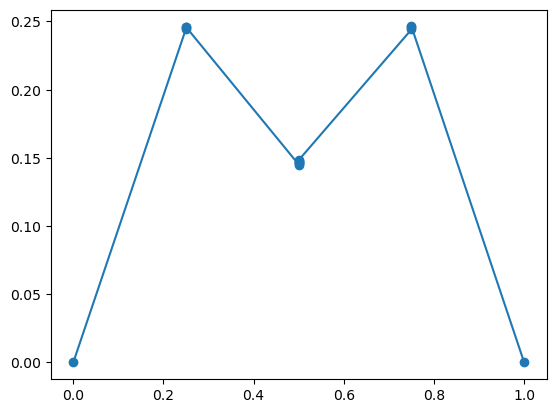

In [29]:
# db_3 = connect("1_2_merged.db")

db_name = "LiNa/LiNaToy-1-Kian.db"
db_1 = connect(db_name)

E = []
x = []
# toExclude = [1,5,7,8,9,15]
toExclude = []


for idx, row in enumerate(db_1.select('')):
    if idx+1 not in toExclude:
        x.append(get_conc_from_formula(row.formula))
        atoms = row.toatoms()
        E.append(atoms.get_potential_energy())

a = np.array(sorted(zip(x, E)))
# a = np.delete(a, -1, 0)

x = a[:,0]
E = a[:,1]

x = np.insert(x, 0, 0.0)
E = np.insert(E, 0, -1297.2531540581*64)
x = np.append(x, 1.0)
E = np.append(E,-196.9072522588681*64)
# E = E + 196.9072522588681*64

for i in range(len(E)):
    E[i] = E[i] + x[i]*196.893*64 + (1-x[i])*1297.246*64

print(E)


Na = E[0]
Li = E[-1]
# Li = -196.9072522588681*80

print("ref", "Na", Na, "Li", Li)

for i in range(len(x)):
    E[i] = (E[i] - x[i]*Li - (1-x[i])*Na)/64
    print(x[i], "\t", E[i])


plt.plot(x, E, '-o')

# print(sortedE)
# print(sortedX)


# for idx, row in enumerate(db_1.select('struct_type=initial')):
#     print(idx, row)
#     db_3.write(row)

# db_name = "LiNa-Aug2-secondBatch.db"
# db_2 = connect(db_name)
# for idx, row in enumerate(db_2.select('')):
#     print(idx, row)
#     db_1.write(row)




In [24]:
template = settings.prim_cell.copy()
# template.numbers[0] = 29
template *= (4,4,4)
# template.numbers[0] = 29
# view(template)
template.write("0.0.db")

In [23]:
template.calc = calc
template.get_potential_energy()

-1088.0

In [3]:
db = connect("LiNa.db")
for row in db.select(''):
    atoms = row.toatoms()
    view(atoms)
    break

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [27]:
settings = CEBulk(crystalstructure='fcc',
                  a=3.8,
                  supercell_factor=64,
                  concentration=Concentration(basis_elements=[['Au', 'Cu']]),
                  db_name="aucu-May31.db",
                  max_cluster_dia=[6.5, 4, 4],
                  basis_func_type="polynomial")

In [8]:
numberOfConc = 21
for i in range(numberOfConc):
    ns = NewStructures(settings, generation_number=genNum, struct_per_gen=1)
    ns.generate_random_structures(atoms=template, conc=np.array([i/(numberOfConc-1), 1-i/(numberOfConc-1)]))
    genNum += 1

In [3]:
genNum = 700
db = connect("LiNa-Aug2-firstBatch-copy-copy.db")
with open('LiNa-Aug2-firstBatch-copy-copy.db-eci.json') as f:
    eci = json.load(f)
iii = 0
skipped = 0
for row in db.select('struct_type=final'):
    print("woring on:", iii)
    template = row.toatoms()
    try:
        ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
        ns.generate_gs_structure(atoms=template, init_temp=1e7,
                                 final_temp=1, num_temp=200,
                                 num_steps_per_temp=5000,
                                 eci=eci, random_composition=True)
        genNum += 1
    except:
        skipped += 1
        print(skipped, "structure skipped")
    iii += 1

woring on: 0
woring on: 1
woring on: 2
woring on: 3


Could not generate ground-state structure in 10 attempts.


1 structure skipped
woring on: 4
woring on: 5
woring on: 6
woring on: 7
woring on: 8
2 structure skipped
woring on: 9
3 structure skipped
woring on: 10
woring on: 11
4 structure skipped
woring on: 12
5 structure skipped
woring on: 13
woring on: 14
6 structure skipped
woring on: 15
7 structure skipped
woring on: 16
8 structure skipped
woring on: 17
woring on: 18
woring on: 19
woring on: 20
woring on: 21
woring on: 22
woring on: 23
woring on: 24
woring on: 25
9 structure skipped
woring on: 26
woring on: 27
10 structure skipped
woring on: 28
11 structure skipped
woring on: 29
12 structure skipped
woring on: 30
woring on: 31
woring on: 32
13 structure skipped
woring on: 33
woring on: 34
woring on: 35
woring on: 36
woring on: 37
14 structure skipped
woring on: 38
woring on: 39
woring on: 40


In [6]:
# db = connect(db_name)
# atoms = None
# for row in db.select(""):
#     atoms = row.toatoms()
#     view(atoms)


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacE

In [13]:
from IsingCalculator import IsingCalc
calc = IsingCalc(E0=0, h=2, J=5, cutoff=3)

db = connect(db_name)

for row in db.select(converged=False):
    atoms = row.toatoms()
    atoms.calc = calc
    atoms.get_potential_energy()
    update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)

Ising E = -564.0
Ising E = -816.0
Ising E = -556.0
Ising E = -588.0
Ising E = -588.0
Ising E = -620.0
Ising E = -1024.0
Ising E = -572.0
Ising E = -912.0
Ising E = -588.0
Ising E = -480.0
Ising E = -640.0
Ising E = -580.0
Ising E = -572.0
Ising E = -576.0
Ising E = -456.0
Ising E = -636.0
Ising E = -620.0
Ising E = -596.0
Ising E = -660.0
Ising E = -556.0
Ising E = -480.0
Ising E = -576.0
Ising E = -636.0
Ising E = -452.0
Ising E = -500.0
Ising E = -516.0
Ising E = -660.0
Ising E = -584.0
Ising E = -576.0
Ising E = -572.0
Ising E = -584.0
Ising E = -508.0
Ising E = -564.0
Ising E = -512.0
Ising E = -572.0
Ising E = -500.0
Ising E = -624.0
Ising E = -592.0
Ising E = -508.0
Ising E = -548.0
Ising E = -544.0
Ising E = -552.0
Ising E = -516.0
Ising E = -584.0
Ising E = -584.0
Ising E = -516.0
Ising E = -580.0
Ising E = -696.0
Ising E = -508.0
Ising E = -636.0
Ising E = -724.0
Ising E = -820.0
Ising E = -528.0
Ising E = -500.0
Ising E = -652.0
Ising E = -508.0
Ising E = -500.0
Ising E = -57

In [18]:
from KianCalculator import KianCalc
calc = KianCalc("LiNa/LiNa-merged-EIM-scaled-calced.db", byOrder=False)

db = connect("LiNa/LiNa-merged-EIM.db")

for idx, row in enumerate(db.select(converged=False)):
    print("???")
    atoms = row.toatoms()
    atoms.calc = calc
    if idx > 0:
        tmpIdx = idx + 1
    else:
        tmpIdx = idx
    if calc.has_energy(row.formula):
        atoms.get_potential_energy()
        update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)

# for row in db.select(converged=False):
#     atoms = row.toatoms()
#     atoms.calc = calc
#     atoms.get_potential_energy()
#     update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
#     calculatedNum += 1
#     print(calculatedNum)

Li 196.4443559597883
Na80 103721.78091845407
Li4Na76 99287.0210113222
Li8Na72 94884.30238639232
Li12Na68 90481.64682607661
Li16Na64 86078.98054767432
Li20Na60 81676.35197988435
Li24Na56 77273.69387514355
Li28Na52 72871.03471335715
Li32Na48 68468.50228330043
Li36Na44 64065.79817150496
Li40Na40 59663.27107246274
Li44Na36 55260.7668970796
Li48Na32 50858.44895416967
Li52Na28 46455.75326543964
Li56Na24 42052.95493445251
Li60Na20 37650.737849954174
Li64Na16 33248.07612551699
Li68Na12 28845.563770198765
Li72Na8 24442.954948682094
Li76Na4 20040.21827646225
Li80 15715.548476783064
Li38Na37 55384.198834056435
Li37Na35 52596.09963085148
Li10Na35 47318.784609737726
Li23Na7 13568.67755008796
Li24Na30 43574.882481997905
Li12Na15 21787.24146113474
Li42Na12 23763.312958611103
Li8Na24 32670.509511644916
Li9Na7 10832.10973727242
Li27Na27 40272.51851292055
Li9Na27 36754.370234418486
Li9Na6 9536.008417876064
Li 196.4443559597883
Na80 103721.78091845407
Li30Na30 44747.72471284276
Li12Na3 6233.975993246158


In [6]:
# db = connect(db_name)
# atoms = None
# for row in db.select(converged=True):
#     atoms = row.toatoms()
#     print(atoms.get_potential_energy())
#     view(atoms)

1


/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_59505/718712354.py:6: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e-4, num_alpha=150)


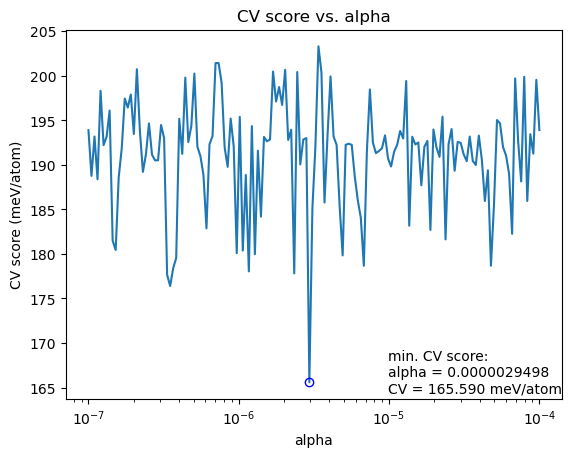

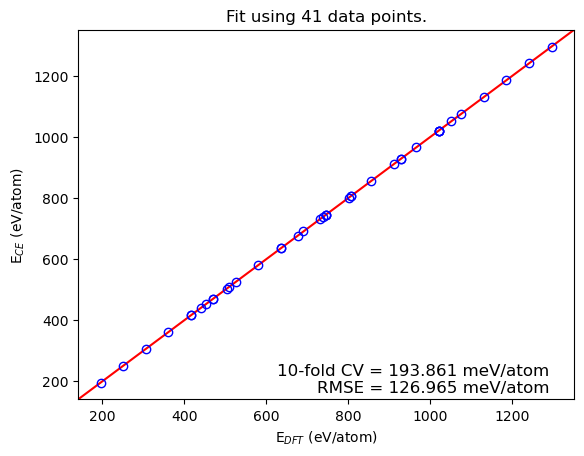

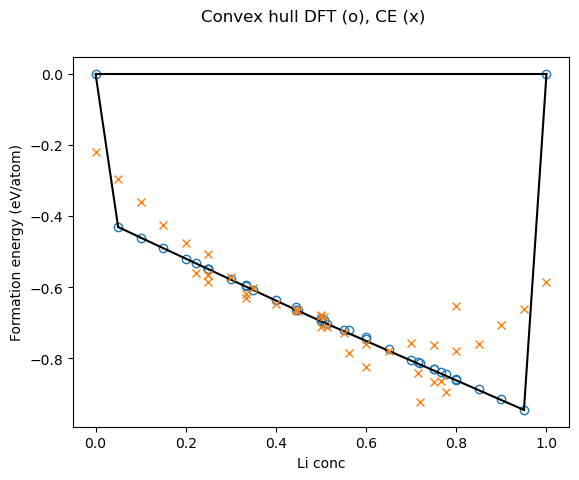

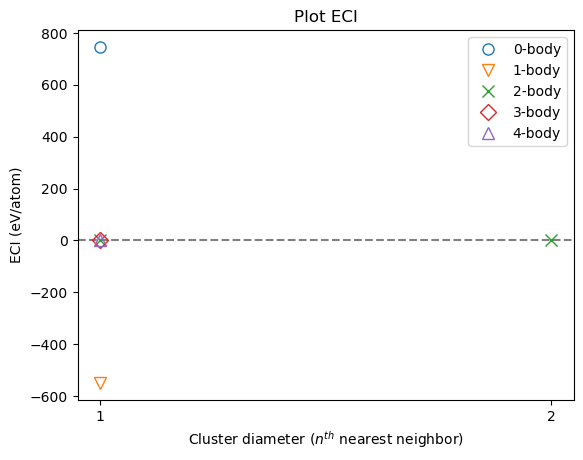

In [19]:
%matplotlib inline

eva = Evaluate(settings=hhsettings, scoring_scheme='k-fold', nsplits=10)
eva.set_fitting_scheme(fitting_scheme='ridge')

alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e-4, num_alpha=150)

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme='ridge', alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

In [11]:
eva.save_eci(fname=db_name + "wtf4-eci.json")

In [11]:
ns = NewStructures(settings, generation_number=2, struct_per_gen=20)
ns.generate_probe_structure()

In [15]:
db = connect("aucu-May31-copy.db")
for i, row in enumerate(db.select("")):
    atoms = row.toatoms()
    view(atoms)
    if i == 3:
        break

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [ ]:
x = - 1
T = 50
N = 64
q = -2
J = -5

kb = 8.617333262e-5
beta = 1/kb/T
a = N * q * J * x**2
b = N * np.log(2) / beta

aa = beta * hEff
c = N * np.log(np.cosh(beta * hEff)) / beta